##### Copyright 2021 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2021 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Retraining an Image Classifier


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/tf2_image_retraining"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/hub/tutorials/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/hub/tutorials/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/hub/tutorials/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/collections/image/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub models</a>
  </td>
</table>

## Introduction

Image classification models have millions of parameters. Training them from
scratch requires a lot of labeled training data and a lot of computing power. Transfer learning is a technique that shortcuts much of this by taking a piece of a model that has already been trained on a related task and reusing it in a new model.

This Colab demonstrates how to build a Keras model for classifying five species of flowers by using a pre-trained TF2 SavedModel from TensorFlow Hub for image feature extraction, trained on the much larger and more general ImageNet dataset. Optionally, the feature extractor can be trained ("fine-tuned") alongside the newly added classifier.

### Looking for a tool instead?

This is a TensorFlow coding tutorial. If you want a tool that just builds the TensorFlow or TFLite model for, take a look at the [make_image_classifier](https://github.com/tensorflow/hub/tree/master/tensorflow_hub/tools/make_image_classifier) command-line tool that gets [installed](https://www.tensorflow.org/hub/installation) by the PIP package `tensorflow-hub[make_image_classifier]`, or at [this](https://colab.sandbox.google.com/github/tensorflow/examples/blob/master/tensorflow_examples/lite/model_maker/demo/image_classification.ipynb) TFLite colab.


In [2]:
!pip install tensorflow
!pip install tensorflow_hub

## Setup

In [3]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.18.0
Hub version: 0.16.1
GPU is NOT AVAILABLE


Compatability issue between keras and tensorflow

In [4]:
import keras

In [5]:
# Use Keras 2.
version_fn = getattr(keras, "version", None)
if version_fn and version_fn().startswith("3."):
  import tf_keras as keras
else:
  keras = tf.keras

## Select the TF2 SavedModel module to use

For starters, use [https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4](https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4). The same URL can be used in code to identify the SavedModel and in your browser to show its documentation. (Note that models in TF1 Hub format won't work here.)

You can find more TF2 models that generate image feature vectors [here](https://tfhub.dev/s?module-type=image-feature-vector&tf-version=tf2).

There are multiple possible models to try. All you need to do is select a different one on the cell below and follow up with the notebook.

In [6]:
#@title

model_name = "mobilenet_v2_100_224" # @param ['efficientnetv2-s', 'efficientnetv2-m', 'efficientnetv2-l', 'efficientnetv2-s-21k', 'efficientnetv2-m-21k', 'efficientnetv2-l-21k', 'efficientnetv2-xl-21k', 'efficientnetv2-b0-21k', 'efficientnetv2-b1-21k', 'efficientnetv2-b2-21k', 'efficientnetv2-b3-21k', 'efficientnetv2-s-21k-ft1k', 'efficientnetv2-m-21k-ft1k', 'efficientnetv2-l-21k-ft1k', 'efficientnetv2-xl-21k-ft1k', 'efficientnetv2-b0-21k-ft1k', 'efficientnetv2-b1-21k-ft1k', 'efficientnetv2-b2-21k-ft1k', 'efficientnetv2-b3-21k-ft1k', 'efficientnetv2-b0', 'efficientnetv2-b1', 'efficientnetv2-b2', 'efficientnetv2-b3', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'bit_s-r50x1', 'inception_v3', 'inception_resnet_v2', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224']

model_handle_map = {
  "efficientnetv2-s": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2",
  "efficientnetv2-m": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_m/feature_vector/2",
  "efficientnetv2-l": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2",
  "efficientnetv2-s-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2",
  "efficientnetv2-m-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/feature_vector/2",
  "efficientnetv2-l-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_l/feature_vector/2",
  "efficientnetv2-xl-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2",
  "efficientnetv2-b0-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2",
  "efficientnetv2-b1-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b1/feature_vector/2",
  "efficientnetv2-b2-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/feature_vector/2",
  "efficientnetv2-b3-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b3/feature_vector/2",
  "efficientnetv2-s-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/feature_vector/2",
  "efficientnetv2-m-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/feature_vector/2",
  "efficientnetv2-l-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_l/feature_vector/2",
  "efficientnetv2-xl-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/feature_vector/2",
  "efficientnetv2-b0-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2",
  "efficientnetv2-b1-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b1/feature_vector/2",
  "efficientnetv2-b2-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b2/feature_vector/2",
  "efficientnetv2-b3-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/feature_vector/2",
  "efficientnetv2-b0": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",
  "efficientnetv2-b1": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/feature_vector/2",
  "efficientnetv2-b2": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b2/feature_vector/2",
  "efficientnetv2-b3": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/feature_vector/2",
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
  "efficientnet_b1": "https://tfhub.dev/tensorflow/efficientnet/b1/feature-vector/1",
  "efficientnet_b2": "https://tfhub.dev/tensorflow/efficientnet/b2/feature-vector/1",
  "efficientnet_b3": "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1",
  "efficientnet_b4": "https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1",
  "efficientnet_b5": "https://tfhub.dev/tensorflow/efficientnet/b5/feature-vector/1",
  "efficientnet_b6": "https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1",
  "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",
  "bit_s-r50x1": "https://tfhub.dev/google/bit/s-r50x1/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature-vector/4",
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature-vector/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature-vector/4",
  "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/feature-vector/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature-vector/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature-vector/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature-vector/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature-vector/4",
  "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/4",
  "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4",
  "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
  "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
  "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5",
  "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
  "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5",
}

model_image_size_map = {
  "efficientnetv2-s": 384,
  "efficientnetv2-m": 480,
  "efficientnetv2-l": 480,
  "efficientnetv2-b0": 224,
  "efficientnetv2-b1": 240,
  "efficientnetv2-b2": 260,
  "efficientnetv2-b3": 300,
  "efficientnetv2-s-21k": 384,
  "efficientnetv2-m-21k": 480,
  "efficientnetv2-l-21k": 480,
  "efficientnetv2-xl-21k": 512,
  "efficientnetv2-b0-21k": 224,
  "efficientnetv2-b1-21k": 240,
  "efficientnetv2-b2-21k": 260,
  "efficientnetv2-b3-21k": 300,
  "efficientnetv2-s-21k-ft1k": 384,
  "efficientnetv2-m-21k-ft1k": 480,
  "efficientnetv2-l-21k-ft1k": 480,
  "efficientnetv2-xl-21k-ft1k": 512,
  "efficientnetv2-b0-21k-ft1k": 224,
  "efficientnetv2-b1-21k-ft1k": 240,
  "efficientnetv2-b2-21k-ft1k": 260,
  "efficientnetv2-b3-21k-ft1k": 300,
  "efficientnet_b0": 224,
  "efficientnet_b1": 240,
  "efficientnet_b2": 260,
  "efficientnet_b3": 300,
  "efficientnet_b4": 380,
  "efficientnet_b5": 456,
  "efficientnet_b6": 528,
  "efficientnet_b7": 600,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
  "nasnet_large": 331,
  "pnasnet_large": 331,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 16#@param {type:"integer"}

Selected model: mobilenet_v2_100_224 : https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4
Input size (224, 224)


## Set up the Flowers dataset

Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

In [7]:
data_dir = keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

228813984/228813984 [==============================] - 8s 0us/step


In [8]:
def build_dataset(subset):
  return keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=.20,
      subset=subset,
      label_mode="categorical",
      # Seed needs to provided when using validation_split and shuffle = True.
      # A fixed seed is used so that the validation set is stable across runs.
      seed=123,
      image_size=IMAGE_SIZE,
      batch_size=1)

train_ds = build_dataset("training")
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()

normalization_layer = keras.layers.Rescaling(1. / 255)
preprocessing_model = keras.Sequential([normalization_layer])
do_data_augmentation = False #@param {type:"boolean"}
if do_data_augmentation:
  preprocessing_model.add(
      keras.layers.RandomRotation(40))
  preprocessing_model.add(
      keras.layers.RandomTranslation(0, 0.2))
  preprocessing_model.add(
      keras.layers.RandomTranslation(0.2, 0))
  # Like the old keras.preprocessing.image.ImageDataGenerator(),
  # image sizes are fixed when reading, and then a random zoom is applied.
  # If all training inputs are larger than image_size, one could also use
  # RandomCrop with a batch size of 1 and rebatch later.
  preprocessing_model.add(
      keras.layers.RandomZoom(0.2, 0.2))
  preprocessing_model.add(
      keras.layers.RandomFlip(mode="horizontal"))
train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))

val_ds = build_dataset("validation")
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


## Defining the model

All it takes is to put a linear classifier on top of the `feature_extractor_layer` with the Hub module.

For speed, we start out with a non-trainable `feature_extractor_layer`, but you can also enable fine-tuning for greater accuracy.

In [9]:
do_fine_tuning = False #@param {type:"boolean"}

In [10]:
print("Building model with", model_handle)
model = keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(len(class_names),
                          kernel_regularizer=keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2264389 (8.64 MB)
Trainable params: 6405 (25.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


#Calculating carbon emissions during model training

In [ ]:
!pip install codecarbon
from codecarbon import EmissionsTracker

## Training the model

In [12]:
model.compile(
  optimizer=keras.optimizers.SGD(learning_rate=0.005, momentum=0.9),
  loss=keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [17]:
#start emissions tracking
tracker = EmissionsTracker()
tracker.start()

#Model training
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
hist = model.fit(
    train_ds,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps).history

#stop emissions tracking
emissions: float = tracker.stop()
print(f"Emissions during training: {emissions} kg CO2")

[codecarbon WARNING @ 20:49:48] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 20:49:48] [setup] RAM Tracking...
[codecarbon INFO @ 20:49:48] [setup] CPU Tracking...
[codecarbon WARNING @ 20:49:49] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 20:49:49] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 20:49:49] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 20:49:49] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 20:49:49] [setup] GPU Tracking...
[codecarbon INFO @ 20:49:49] No GPU found.
[codecarbon INFO @ 20:49:49] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

Epoch 1/5
 30/183 [===>..........................] - ETA: 1:12 - loss: 0.5950 - accuracy: 0.9417

[codecarbon INFO @ 20:50:05] Energy consumed for RAM : 0.000042 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:50:05] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 20:50:05] Energy consumed for All CPU : 0.000178 kWh
[codecarbon INFO @ 20:50:05] 0.000219 kWh of electricity used since the beginning.


 66/183 [=========>....................] - ETA: 51s - loss: 0.5879 - accuracy: 0.9432

[codecarbon INFO @ 20:50:20] Energy consumed for RAM : 0.000083 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:50:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:50:20] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 20:50:20] 0.000438 kWh of electricity used since the beginning.


100/183 [===============>..............] - ETA: 36s - loss: 0.5877 - accuracy: 0.9425

[codecarbon INFO @ 20:50:35] Energy consumed for RAM : 0.000125 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:50:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:50:35] Energy consumed for All CPU : 0.000531 kWh
[codecarbon INFO @ 20:50:35] 0.000656 kWh of electricity used since the beginning.


136/183 [=====================>........] - ETA: 20s - loss: 0.5943 - accuracy: 0.9380

[codecarbon INFO @ 20:50:50] Energy consumed for RAM : 0.000167 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:50:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:50:50] Energy consumed for All CPU : 0.000708 kWh
[codecarbon INFO @ 20:50:50] 0.000875 kWh of electricity used since the beginning.


170/183 [==========================>...] - ETA: 5s - loss: 0.5980 - accuracy: 0.9364

[codecarbon INFO @ 20:51:05] Energy consumed for RAM : 0.000208 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:51:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:51:05] Energy consumed for All CPU : 0.000886 kWh
[codecarbon INFO @ 20:51:05] 0.001094 kWh of electricity used since the beginning.


183/183 [==============================] - ETA: 0s - loss: 0.6014 - accuracy: 0.9355

[codecarbon INFO @ 20:51:20] Energy consumed for RAM : 0.000250 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:51:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:51:20] Energy consumed for All CPU : 0.001063 kWh
[codecarbon INFO @ 20:51:20] 0.001313 kWh of electricity used since the beginning.


183/183 [==============================] - 100s 547ms/step - loss: 0.6014 - accuracy: 0.9355 - val_loss: 0.7277 - val_accuracy: 0.8667
Epoch 2/5
 12/183 [>.............................] - ETA: 1:05 - loss: 0.6310 - accuracy: 0.9076

[codecarbon INFO @ 20:51:35] Energy consumed for RAM : 0.000292 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:51:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:51:35] Energy consumed for All CPU : 0.001240 kWh
[codecarbon INFO @ 20:51:35] 0.001531 kWh of electricity used since the beginning.


 45/183 [======>.......................] - ETA: 59s - loss: 0.5895 - accuracy: 0.9452

[codecarbon INFO @ 20:51:50] Energy consumed for RAM : 0.000333 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:51:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:51:50] Energy consumed for All CPU : 0.001417 kWh
[codecarbon INFO @ 20:51:50] 0.001750 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:51:50] 0.009363 g.CO2eq/s mean an estimation of 295.2725681057116 kg.CO2eq/year


 77/183 [===========>..................] - ETA: 47s - loss: 0.5862 - accuracy: 0.9444

[codecarbon INFO @ 20:52:05] Energy consumed for RAM : 0.000375 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:52:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:52:05] Energy consumed for All CPU : 0.001594 kWh
[codecarbon INFO @ 20:52:05] 0.001969 kWh of electricity used since the beginning.


110/183 [=================>............] - ETA: 32s - loss: 0.5861 - accuracy: 0.9412

[codecarbon INFO @ 20:52:20] Energy consumed for RAM : 0.000417 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:52:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:52:20] Energy consumed for All CPU : 0.001771 kWh
[codecarbon INFO @ 20:52:20] 0.002187 kWh of electricity used since the beginning.


145/183 [======================>.......] - ETA: 16s - loss: 0.5889 - accuracy: 0.9399

[codecarbon INFO @ 20:52:35] Energy consumed for RAM : 0.000458 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:52:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:52:35] Energy consumed for All CPU : 0.001948 kWh
[codecarbon INFO @ 20:52:35] 0.002406 kWh of electricity used since the beginning.


167/183 [==========================>...] - ETA: 7s - loss: 0.5885 - accuracy: 0.9414

[codecarbon INFO @ 20:52:50] Energy consumed for RAM : 0.000500 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:52:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:52:50] Energy consumed for All CPU : 0.002125 kWh
[codecarbon INFO @ 20:52:50] 0.002625 kWh of electricity used since the beginning.


183/183 [==============================] - ETA: 0s - loss: 0.5900 - accuracy: 0.9418

[codecarbon INFO @ 20:53:05] Energy consumed for RAM : 0.000542 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:53:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:53:05] Energy consumed for All CPU : 0.002302 kWh
[codecarbon INFO @ 20:53:05] 0.002843 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:53:20] Energy consumed for RAM : 0.000583 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:53:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:53:20] Energy consumed for All CPU : 0.002479 kWh
[codecarbon INFO @ 20:53:20] 0.003062 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:53:35] Energy consumed for RAM : 0.000625 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:53:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:53:35] Energy consumed for All CPU : 0.002656 kWh
[codecarbon INFO @ 20:53:35] 0.003281 kWh 

183/183 [==============================] - 134s 735ms/step - loss: 0.5900 - accuracy: 0.9418 - val_loss: 0.6587 - val_accuracy: 0.8972
Epoch 3/5
 12/183 [>.............................] - ETA: 1:21 - loss: 0.6645 - accuracy: 0.8696

[codecarbon INFO @ 20:53:50] Energy consumed for RAM : 0.000666 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:53:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:53:50] Energy consumed for All CPU : 0.002833 kWh
[codecarbon INFO @ 20:53:50] 0.003500 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:53:50] 0.009364 g.CO2eq/s mean an estimation of 295.29037503637966 kg.CO2eq/year


 48/183 [======>.......................] - ETA: 58s - loss: 0.6064 - accuracy: 0.9289

[codecarbon INFO @ 20:54:05] Energy consumed for RAM : 0.000708 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:54:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:54:05] Energy consumed for All CPU : 0.003010 kWh
[codecarbon INFO @ 20:54:05] 0.003719 kWh of electricity used since the beginning.


 84/183 [============>.................] - ETA: 41s - loss: 0.5883 - accuracy: 0.9401

[codecarbon INFO @ 20:54:20] Energy consumed for RAM : 0.000750 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:54:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:54:20] Energy consumed for All CPU : 0.003188 kWh
[codecarbon INFO @ 20:54:20] 0.003937 kWh of electricity used since the beginning.


120/183 [==================>...........] - ETA: 26s - loss: 0.5886 - accuracy: 0.9378

[codecarbon INFO @ 20:54:35] Energy consumed for RAM : 0.000792 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:54:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:54:35] Energy consumed for All CPU : 0.003365 kWh
[codecarbon INFO @ 20:54:35] 0.004156 kWh of electricity used since the beginning.


154/183 [========================>.....] - ETA: 12s - loss: 0.5907 - accuracy: 0.9357

[codecarbon INFO @ 20:54:50] Energy consumed for RAM : 0.000833 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:54:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:54:50] Energy consumed for All CPU : 0.003542 kWh
[codecarbon INFO @ 20:54:50] 0.004375 kWh of electricity used since the beginning.


183/183 [==============================] - ETA: 0s - loss: 0.5959 - accuracy: 0.9315

[codecarbon INFO @ 20:55:05] Energy consumed for RAM : 0.000875 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:55:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:55:05] Energy consumed for All CPU : 0.003719 kWh
[codecarbon INFO @ 20:55:05] 0.004594 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:55:20] Energy consumed for RAM : 0.000916 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:55:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:55:20] Energy consumed for All CPU : 0.003896 kWh
[codecarbon INFO @ 20:55:20] 0.004812 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:55:35] Energy consumed for RAM : 0.000958 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:55:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:55:35] Energy consumed for All CPU : 0.004073 kWh
[codecarbon INFO @ 20:55:35] 0.005031 kWh 

183/183 [==============================] - 119s 651ms/step - loss: 0.5959 - accuracy: 0.9315 - val_loss: 0.6625 - val_accuracy: 0.8986
Epoch 4/5
 15/183 [=>............................] - ETA: 1:17 - loss: 0.5916 - accuracy: 0.9440

[codecarbon INFO @ 20:55:50] Energy consumed for RAM : 0.001000 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:55:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:55:50] Energy consumed for All CPU : 0.004250 kWh
[codecarbon INFO @ 20:55:50] 0.005250 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:55:50] 0.009364 g.CO2eq/s mean an estimation of 295.29067776267465 kg.CO2eq/year


 51/183 [=======>......................] - ETA: 56s - loss: 0.5804 - accuracy: 0.9468

[codecarbon INFO @ 20:56:05] Energy consumed for RAM : 0.001041 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:56:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:56:05] Energy consumed for All CPU : 0.004427 kWh
[codecarbon INFO @ 20:56:05] 0.005469 kWh of electricity used since the beginning.


 87/183 [=============>................] - ETA: 40s - loss: 0.5749 - accuracy: 0.9501

[codecarbon INFO @ 20:56:20] Energy consumed for RAM : 0.001083 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:56:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:56:20] Energy consumed for All CPU : 0.004604 kWh
[codecarbon INFO @ 20:56:20] 0.005688 kWh of electricity used since the beginning.


123/183 [===================>..........] - ETA: 25s - loss: 0.5767 - accuracy: 0.9495

[codecarbon INFO @ 20:56:35] Energy consumed for RAM : 0.001125 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:56:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:56:35] Energy consumed for All CPU : 0.004782 kWh
[codecarbon INFO @ 20:56:35] 0.005906 kWh of electricity used since the beginning.


156/183 [========================>.....] - ETA: 11s - loss: 0.5783 - accuracy: 0.9486

[codecarbon INFO @ 20:56:50] Energy consumed for RAM : 0.001166 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:56:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:56:50] Energy consumed for All CPU : 0.004959 kWh
[codecarbon INFO @ 20:56:50] 0.006125 kWh of electricity used since the beginning.


183/183 [==============================] - ETA: 0s - loss: 0.5809 - accuracy: 0.9466

[codecarbon INFO @ 20:57:05] Energy consumed for RAM : 0.001208 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:57:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:57:05] Energy consumed for All CPU : 0.005136 kWh
[codecarbon INFO @ 20:57:05] 0.006344 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:57:20] Energy consumed for RAM : 0.001250 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:57:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:57:20] Energy consumed for All CPU : 0.005313 kWh
[codecarbon INFO @ 20:57:20] 0.006563 kWh of electricity used since the beginning.


183/183 [==============================] - 98s 537ms/step - loss: 0.5809 - accuracy: 0.9466 - val_loss: 0.6811 - val_accuracy: 0.8861
Epoch 5/5
 33/183 [====>.........................] - ETA: 1:03 - loss: 0.5855 - accuracy: 0.9442

[codecarbon INFO @ 20:57:35] Energy consumed for RAM : 0.001291 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:57:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:57:35] Energy consumed for All CPU : 0.005490 kWh
[codecarbon INFO @ 20:57:35] 0.006781 kWh of electricity used since the beginning.


 68/183 [==========>...................] - ETA: 48s - loss: 0.5632 - accuracy: 0.9537

[codecarbon INFO @ 20:57:50] Energy consumed for RAM : 0.001333 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:57:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:57:50] Energy consumed for All CPU : 0.005667 kWh
[codecarbon INFO @ 20:57:50] 0.007000 kWh of electricity used since the beginning.
[codecarbon INFO @ 20:57:50] 0.009363 g.CO2eq/s mean an estimation of 295.2741272568571 kg.CO2eq/year


104/183 [================>.............] - ETA: 33s - loss: 0.5724 - accuracy: 0.9487

[codecarbon INFO @ 20:58:05] Energy consumed for RAM : 0.001375 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:58:05] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:58:05] Energy consumed for All CPU : 0.005844 kWh
[codecarbon INFO @ 20:58:05] 0.007219 kWh of electricity used since the beginning.


138/183 [=====================>........] - ETA: 19s - loss: 0.5734 - accuracy: 0.9505

[codecarbon INFO @ 20:58:20] Energy consumed for RAM : 0.001416 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:58:20] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:58:20] Energy consumed for All CPU : 0.006021 kWh
[codecarbon INFO @ 20:58:20] 0.007438 kWh of electricity used since the beginning.


172/183 [===========================>..] - ETA: 4s - loss: 0.5786 - accuracy: 0.9464

[codecarbon INFO @ 20:58:35] Energy consumed for RAM : 0.001458 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:58:35] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:58:35] Energy consumed for All CPU : 0.006198 kWh
[codecarbon INFO @ 20:58:35] 0.007656 kWh of electricity used since the beginning.


183/183 [==============================] - ETA: 0s - loss: 0.5776 - accuracy: 0.9462

[codecarbon INFO @ 20:58:50] Energy consumed for RAM : 0.001500 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:58:50] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 20:58:50] Energy consumed for All CPU : 0.006375 kWh
[codecarbon INFO @ 20:58:50] 0.007875 kWh of electricity used since the beginning.


183/183 [==============================] - 99s 540ms/step - loss: 0.5776 - accuracy: 0.9462 - val_loss: 0.6778 - val_accuracy: 0.8972


[codecarbon INFO @ 20:58:59] Energy consumed for RAM : 0.001526 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 20:58:59] Delta energy consumed for CPU with constant : 0.000113 kWh, power : 42.5 W
[codecarbon INFO @ 20:58:59] Energy consumed for All CPU : 0.006488 kWh
[codecarbon INFO @ 20:58:59] 0.008014 kWh of electricity used since the beginning.


Emissions during training: 0.00514811434692742 kg CO2


In [21]:
emissions_data = tracker.final_emissions_data
print(f"Energy consumed: {emissions_data.energy_consumed:.6f} kWh")
print(f"Execution Time: {emissions_data.duration:.2f} seconds")
print(f"Emissions: {emissions_data.emissions} kg CO2")

Energy consumed: 0.008014 kWh
Execution Time: 549.82 seconds
Emissions: 0.00514811434692742 kg CO2


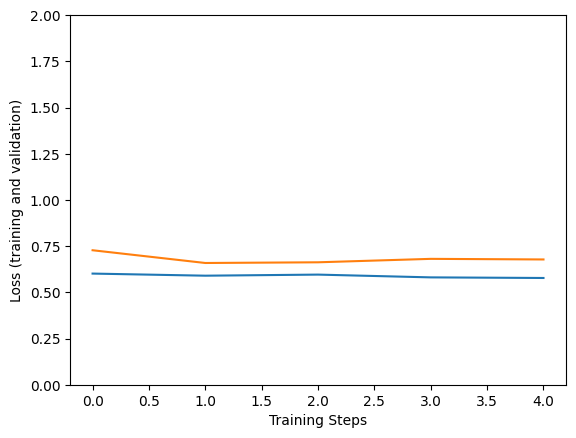

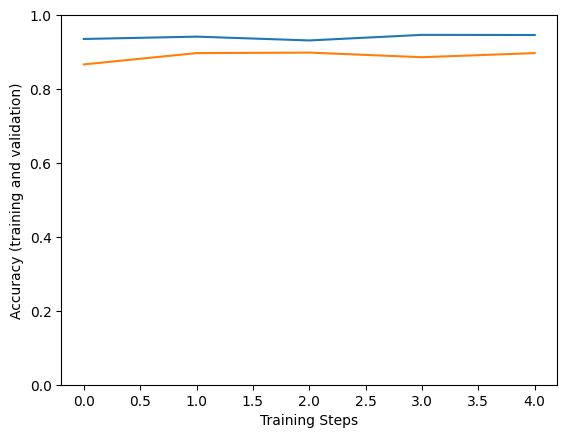

In [22]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

Try out the model on an image from the validation data:

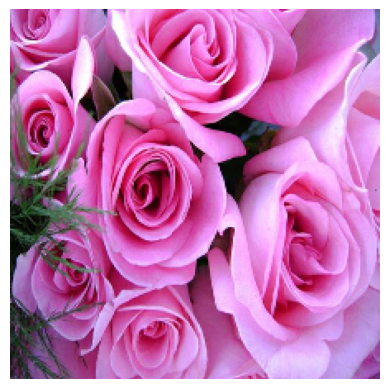

1/1 [==============================] - 0s 48ms/step
True label: roses
Predicted label: roses


In [23]:
x, y = next(iter(val_ds))
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])